# Lunar Lander #

## Imports ##

In [43]:
import gymnasium as gym
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import matplotlib.animation as animation

## Environnement ##

In [34]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

## Modeles ##

In [35]:
models = {
    "DQN": DQN("MlpPolicy", env, verbose=1),
    "PPO": PPO("MlpPolicy", env, verbose=1),
    "A2C": A2C("MlpPolicy", env, verbose=1)
}

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Callback ##

In [36]:
class RewardCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []

    def _on_step(self) -> bool:
        if len(self.locals["infos"]) > 0 and "episode" in self.locals["infos"][0]:
            self.episode_rewards.append(self.locals["infos"][0]["episode"]["r"])
        return True

## Entrainement ##

In [37]:
timesteps = 200000 
results = {}
reward_histories = {}

for name, model in models.items():
    print(f"\n=== Entraînement de {name} ===")
    callback = RewardCallback()
    model.learn(total_timesteps=timesteps, callback=callback)

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    results[name] = {
        "mean_reward": mean_reward,
        "std_reward": std_reward
    }
    reward_histories[name] = callback.episode_rewards

    print(f"{name} - Score moyen: {mean_reward:.2f} ± {std_reward:.2f}")


=== Entraînement de DQN ===
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.2     |
|    ep_rew_mean      | -193     |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1956     |
|    time_elapsed     | 0        |
|    total_timesteps  | 393      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 73       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90       |
|    ep_rew_mean      | -150     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2274     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


DQN - Score moyen: -83.90 ± 19.26

=== Entraînement de PPO ===
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.4     |
|    ep_rew_mean     | -199     |
| time/              |          |
|    fps             | 2440     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 86.4         |
|    ep_rew_mean          | -187         |
| time/                   |              |
|    fps                  | 2321         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058891047 |
|    clip_fraction        | 0.0389       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38     

## Tableau comparatif ##

In [38]:
df_results = pd.DataFrame(results).T
print("\n=== Résultats comparatifs ===")
print(df_results)


=== Résultats comparatifs ===
     mean_reward  std_reward
DQN   -83.903166   19.262759
PPO    89.582560  105.717302
A2C   103.529980  113.859267


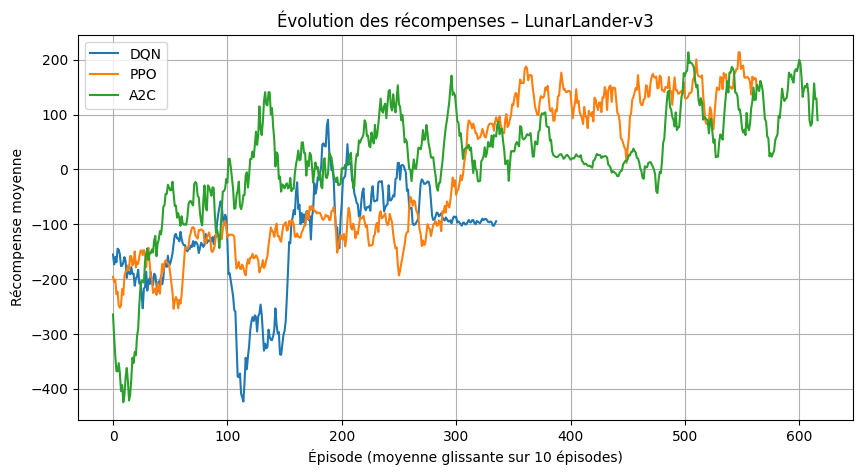

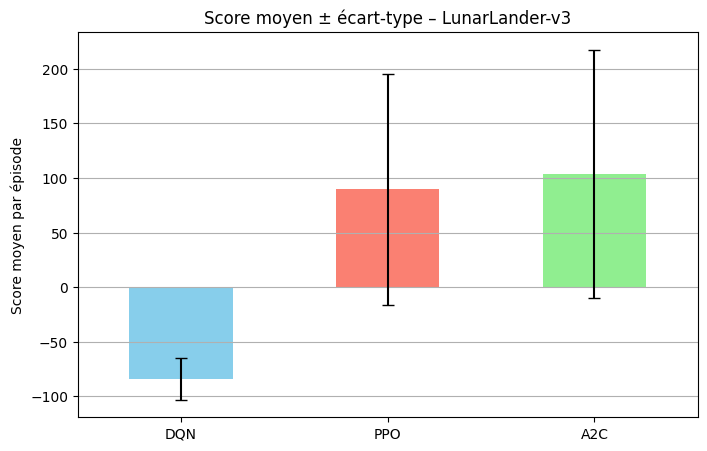

In [45]:
def moving_average(x, n=10):
    """Calcule la moyenne glissante sur n points"""
    return np.convolve(x, np.ones(n)/n, mode='valid')

plt.figure(figsize=(10, 5))
for name, rewards in reward_histories.items():
    if len(rewards) >= 10:
        plt.plot(moving_average(rewards, n=10), label=name)
    else:
        plt.plot(rewards, label=name)

plt.xlabel("Épisode (moyenne glissante sur 10 épisodes)")
plt.ylabel("Récompense moyenne")
plt.title("Évolution des récompenses – LunarLander-v3")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
df_results["mean_reward"].plot(
    kind="bar",
    yerr=df_results["std_reward"],
    capsize=4,
    color=["skyblue", "salmon", "lightgreen"],
    title="Score moyen ± écart-type – LunarLander-v3"
)
plt.ylabel("Score moyen par épisode")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

## Visualisation du meilleur modele ##

In [46]:
best_model_name = df_results["mean_reward"].idxmax()
best_model = models[best_model_name]

obs, info = env.reset()
frames = []
done = False

while not done:
    action, _ = best_model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    done = terminated or truncated

fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)
plt.close(fig)
display(HTML(ani.to_jshtml()))